# Create media designs suggested by ART

We use ART to provide suggested designs for media components for which to get phenotypic data. 

For DBTL 4 we create 8 designs from an exploratory mode with $\alpha=1.$, 7 designs from the exploitation mode ($\alpha=0$) and 1 design being close to the standard media as a control, totalling 16 designs in triplicates. 

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required files to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`
- EDD study slug(s)

**File generated by running this notebook**

- 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
import re
import warnings
    
from art.core import *
import art.plot as plot
import edd_utils as eddu

from core import designs_pairwise

## User parameters

In [2]:
CYCLE = 4

user_params = {
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/flaviolin/standard_recipe_concentrations.csv',
    'study_slug_1': 'combinatorial-media-for-flaviolin-dbtl1-ed1e',
    'study_slug_2': 'combinatorial-media-for-flaviolin-dbtl-2',
    'study_slug_3': 'combinatorial-media-for-flaviolin-dbtl-3',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
}


Specify which components to explore and which response to optimize:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

user_params['response'] = 'OD340'

Here we specify how many instances (designs) we want to create and how many replicates: 

In [4]:
user_params['n_instances_explor'] = 8
user_params['n_instances_exploit'] = 7
user_params['n_replicates'] = 3

## Load the data

In [5]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
edd_server = user_params['edd_server']
username = user_params['username']

In [6]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [7]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')



  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [8]:
df_1.head(2)

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148494,Combinatorial media for flaviolin DBTL1,148495,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148543,C1_WA1_A4-R1,NaN,Optical Density,0,NaN,0.4422,48.0
1,148494,Combinatorial media for flaviolin DBTL1,148496,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148544,C1_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3405,48.0


In [9]:
df_2.head(2)

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148639,Combinatorial media for flaviolin DBTL 2,148640,C2_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148688,C2_WA1_A4-R1,NaN,Optical Density,0,NaN,0.3717,48.0
1,148639,Combinatorial media for flaviolin DBTL 2,148641,C2_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148689,C2_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3748,48.0


In [10]:
df_3.head(2)

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148929,Combinatorial media for flaviolin DBTL 3,148930,C3_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD600,148978,C3_WA1_C1-R1,NaN,Optical Density,0,NaN,1.492,48.0
1,148929,Combinatorial media for flaviolin DBTL 3,148931,C3_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD600,148979,C3_WA1_C1-R2,NaN,Optical Density,0,NaN,1.016,48.0


Concatenate the three studies:

In [11]:
df = df_1.append(df_2).append(df_3)

Drop unnecessary columns:

In [12]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [13]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


### Adding media information to the data frame

Add columns for each component:

In [14]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [15]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
139,C3_WD7_F7-R2,0.5415,0.884,40.0,4.0,0.006221,20.0,0.150431,6.409492,0.07174,7.294398,1.09227,384.376373,0.00029,0.002585,0.000905,0.00288,0.000835
140,C3_WD7_F7-R3,0.5294,0.887,40.0,4.0,0.006221,20.0,0.150431,6.409492,0.07174,7.294398,1.09227,384.376373,0.00029,0.002585,0.000905,0.00288,0.000835
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098
143,C3_WD8_F8-R3,0.2905,0.788,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In DBTL 3 is stored in the last column (D8, E8, F8).

In [16]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

In [17]:
control_lines

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
44,C1_WF5_F8-R1,0.2856,0.731,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
45,C1_WF5_F8-R2,0.2936,0.763,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
46,C1_WF5_F8-R3,0.2715,0.664,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
47,C1_WF5_F8-R4,0.2891,0.795,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


How many designs improve response over the standard recipe?

In [18]:
control_response = np.max(control_lines['OD340'])
num_improved_response = np.sum(df['OD340'] > control_response)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of OD340 ({num_improved_response/num_designs*100:.2f}%).')


94 samples out of 133 improve over the standard in terms of OD340 (70.68%).


### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [19]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS,40.0
3,C1_WA1_A4-R1,Tricine,4.0
4,C1_WA1_A4-R1,H3BO3,0.003744


# Media designs recommendations

## ART generated media

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [20]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'verbose': 1
}


We will first run only model building part and then proceed with optimization using the two modes - exploration and exploitation>

In [21]:
user_params['alpha_explor'] = 1.0
user_params['alpha_exploit'] = None

With the configuration stored in art_params, we now run ART:

In [22]:
run_art = True

Best pipeline: ExtraTreesRegressor(AdaBoostRegressor(XGBRegressor(SGDRegressor(LinearSVR(input_matrix, C=0.001, dual=False, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.1), alpha=0.01, eta0=1.0, fit_intercept=True, l1_ratio=0.25, learning_rate=invscaling, loss=squared_loss, penalty=elasticnet, power_t=1.0), learning_rate=0.01, max_depth=2, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0), learning_rate=0.001, loss=exponential, n_estimators=100), bootstrap=False, max_features=0.55, min_samples_leaf=2, min_samples_split=12, n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 22000/22000 [00:27<00:00, 813.42draws/s]
The acceptance probability does not match the target. It is 0.8806413082346789, but should be close to 0.8. Try to increase the number of tuning steps.


Best pipeline: RidgeCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.5, min_samples_leaf=19, min_samples_split=20, n_estimators=100))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 22000/22000 [00:25<00:00, 853.64draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6209737101595142, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Best pipeline: XGBRegressor(CombineDFs(VarianceThreshold(input_matrix, threshold=0.05), input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 9 divergences: 100%|██████████| 22000/22000 [00:22<00:00, 990.16draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Best pipeline: XGBRegressor(RidgeCV(DecisionTreeRegressor(input_matrix, max_depth=10, min_samples_leaf=6, min_samples_split=12)), learning_rate=0.1, max_depth=1, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 30 divergences: 100%|██████████| 22000/22000 [00:32<00:00, 682.52draws/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6081623610436194, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Best pipeline: RidgeCV(RandomForestRegressor(CombineDFs(input_matrix, RBFSampler(input_matrix, gamma=0.25)), bootstrap=True, max_features=0.1, min_samples_leaf=15, min_samples_split=12, n_estimators=100))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 15 divergences: 100%|██████████| 22000/22000 [00:23<00:00, 956.05draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


Best pipeline: ExtraTreesRegressor(PolynomialFeatures(RandomForestRegressor(CombineDFs(CombineDFs(input_matrix, input_matrix), input_matrix), bootstrap=False, max_features=0.2, min_samples_leaf=17, min_samples_split=8, n_estimators=100), degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.55, min_samples_leaf=5, min_samples_split=8, n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 2 divergences: 100%|██████████| 22000/22000 [00:22<00:00, 977.58draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Best pipeline: LassoLarsCV(XGBRegressor(ElasticNetCV(SGDRegressor(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5, learning_rate=constant, loss=huber, penalty=elasticnet, power_t=0.1), l1_ratio=0.65, tol=0.001), learning_rate=0.1, max_depth=5, min_child_weight=19, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0), normalize=True)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 22000/22000 [00:24<00:00, 889.42draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: RidgeCV(RandomForestRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.4, min_samples_leaf=17, min_samples_split=8, n_estimators=100), bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=9, min_samples_split=20, n_estimators=100))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 108 divergences: 100%|██████████| 22000/22000 [00:32<00:00, 685.70draws/s]
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5988716229208, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Best pipeline: RandomForestRegressor(LinearSVR(input_matrix, C=0.01, dual=True, epsilon=0.001, loss=epsilon_insensitive, tol=0.0001), bootstrap=False, max_features=0.4, min_samples_leaf=1, min_samples_split=15, n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 3 divergences: 100%|██████████| 22000/22000 [00:24<00:00, 905.75draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Best pipeline: XGBRegressor(VarianceThreshold(input_matrix, threshold=0.001), learning_rate=0.1, max_depth=5, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 30 divergences: 100%|██████████| 22000/22000 [00:24<00:00, 908.89draws/s] 
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6827058633098313, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.136741,42.853627,0.118454,0.032729,-0.336298
Random Forest Regressor,0.051795,15.651368,0.056149,0.005835,0.761748
TPOT Regressor,0.052860,15.655140,0.046705,0.004976,0.796856
Support Vector Regressor,0.080798,25.453128,0.049343,0.008963,0.634054
Kernel Ridge Regressor,0.098469,26.393023,0.071591,0.014821,0.394860
K-NN Regressor,0.075677,24.921298,0.074023,0.011206,0.542457
Gaussian Process Regressor,0.052253,15.586225,0.040687,0.004386,0.820934
Gradient Boosting Regressor,0.049448,14.837325,0.053671,0.005326,0.782559
Ensemble Model,0.049000,14.998803,0.041175,0.004096,0.832747


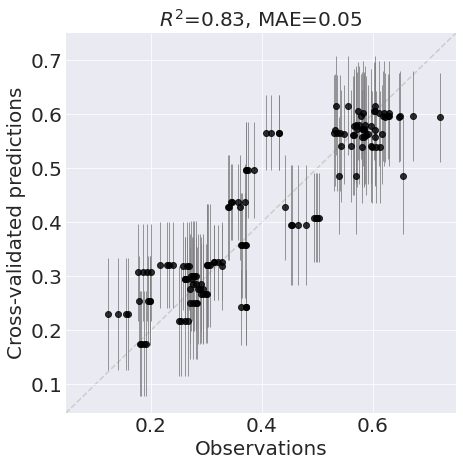

Best pipeline: XGBRegressor(VarianceThreshold(input_matrix, threshold=0.001), learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains, 43 divergences: 100%|██████████| 22000/22000 [00:22<00:00, 961.64draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.068133,19.652915,0.047798,0.006927,0.717188
Random Forest Regressor,0.011662,2.916609,0.013101,0.000308,0.987440
TPOT Regressor,0.012358,3.131449,0.013240,0.000328,0.986607
Support Vector Regressor,0.061078,18.559063,0.029147,0.004580,0.813004
Kernel Ridge Regressor,0.019889,5.306377,0.016456,0.000666,0.972792
K-NN Regressor,0.023279,7.160569,0.020876,0.000978,0.960082
Gaussian Process Regressor,0.011988,3.025002,0.012872,0.000309,0.987367
Gradient Boosting Regressor,0.011587,2.886880,0.012874,0.000300,0.987752
Ensemble Model,0.012273,3.099473,0.013301,0.000328,0.986626


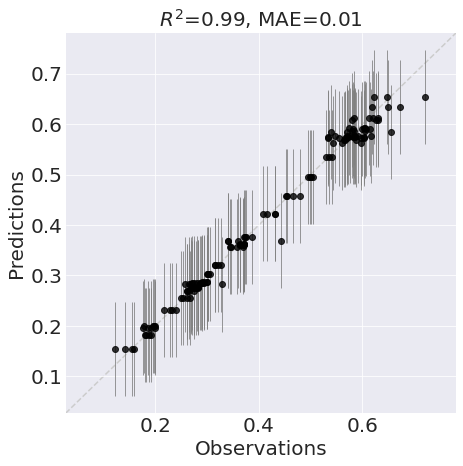

CPU times: user 55min 5s, sys: 1h 8min 21s, total: 2h 3min 26s
Wall time: 29min 33s


In [23]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [25]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.136741,42.853627,0.118454,0.032729,-0.336298
Random Forest Regressor,0.051795,15.651368,0.056149,0.005835,0.761748
TPOT Regressor,0.052860,15.655140,0.046705,0.004976,0.796856
Support Vector Regressor,0.080798,25.453128,0.049343,0.008963,0.634054
Kernel Ridge Regressor,0.098469,26.393023,0.071591,0.014821,0.394860
K-NN Regressor,0.075677,24.921298,0.074023,0.011206,0.542457
Gaussian Process Regressor,0.052253,15.586225,0.040687,0.004386,0.820934
Gradient Boosting Regressor,0.049448,14.837325,0.053671,0.005326,0.782559
Ensemble Model,0.049000,14.998803,0.041175,0.004096,0.832747


### Exploitation recommendations

In [26]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_exploit']
draws = art.parallel_tempering_opt()


Finished 2.00 percent in 9.155422 s Acceptance rate = 0.601Adding DE jump with weight 20
Finished 99.00 percent in 345.666697 s Acceptance rate = 0.447081
Run Complete
CPU times: user 5min 36s, sys: 1.97 s, total: 5min 38s
Wall time: 5min 49s


In [27]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_exploit.txt"
os.rename(orig_file_name, new_file_name)

In [28]:
art.num_recommendations = user_params['n_instances_exploit'] # 7 in this DBTL4
art.rel_rec_distance = 2. # Default is 0.2
# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 
# Stops when 7 recommendations are found.

# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.
art.recommend(draws)


,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.024773,0.700826,4.062760,0.047732,12.929126,2.133702,414.274311,0.000250,0.001827,0.000484,0.004128,0.000014,0.578698
1,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.000290,0.000688,0.002765,0.000014,0.513430
2,0.008170,2.278140,5.092978,0.077865,11.739814,1.428153,411.076753,0.000279,0.000292,0.000689,0.003862,0.000014,0.511907
3,0.018280,2.206493,3.451213,0.059624,12.453609,0.332198,401.210566,0.000221,0.002911,0.000710,0.004350,0.000014,0.500242
4,0.014316,2.154430,2.710952,0.080738,10.910402,4.790117,456.776681,0.000184,0.000292,0.000689,0.001921,0.000014,0.497449
5,0.009734,2.242214,4.680379,0.056417,9.194358,1.921812,392.324374,0.000141,0.001184,0.000696,0.004599,0.000014,0.494262
6,0.033092,2.159783,3.831534,0.066500,9.140576,3.331034,469.248028,0.000276,0.001106,0.000486,0.000465,0.000014,0.490792


In [29]:
df_rec_exploit = art.recommendations.copy()

Add standard deviation for the predictions:

In [30]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_exploit.values[:, :-1]
        ) # posterior predictive statistics: mean and std

df_rec_exploit['OD340_std'] = predicted_std
df_rec_exploit['Label'] = 'exploitation' # will be used for plotting in the parity plot in notebook F

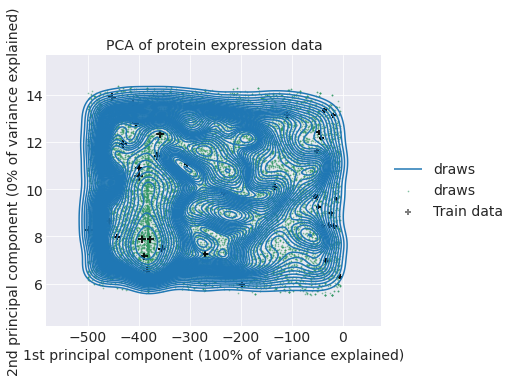

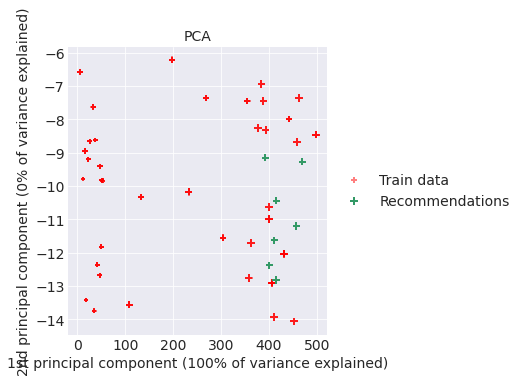

In [31]:
plot.draws_pc(art, draws, scale=100, plot_draws=True, plot_kde=True)
plot.recommendations_pc(art, scale=100)


In [32]:
plot.model_pairwise(art)

### Exploration recommendations

In [33]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()


Finished 2.00 percent in 8.985280 s Acceptance rate = 0.589Adding DE jump with weight 20
Finished 99.00 percent in 317.986091 s Acceptance rate = 0.414026
Run Complete
CPU times: user 5min 9s, sys: 1.6 s, total: 5min 10s
Wall time: 5min 21s


In [34]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_explor.txt"
os.rename(orig_file_name, new_file_name)

In [35]:
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 3.
art.recommend(draws)

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.026205,2.868647,3.063754,0.051305,8.628131,5.058487,390.089741,0.000030,0.000393,0.000282,0.003961,0.000835,0.404899
1,0.037669,0.800197,1.415873,0.084858,13.717068,1.459033,323.896805,0.000296,0.002085,0.000992,0.005032,0.000835,0.452337
2,0.000523,2.849896,5.943808,0.079905,8.446208,4.240846,367.255495,0.000123,0.002005,0.000048,0.003702,0.000835,0.408803
3,0.000705,2.224790,6.153711,0.097613,14.043278,4.794772,394.734535,0.000037,0.002773,0.000990,0.006802,0.000835,0.450592
4,0.003253,2.266566,6.438007,0.054262,9.212677,2.150364,404.691896,0.000010,0.002287,0.000066,0.001922,0.000835,0.429996
5,0.039067,2.582378,5.991768,0.078723,8.607087,4.521068,381.318487,0.000033,0.001623,0.000992,0.000209,0.000835,0.416583
6,0.032352,2.681768,6.293779,0.003636,13.057300,1.678010,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.430691
7,0.010556,2.601029,5.705683,0.082804,12.939917,3.939057,475.957694,0.000033,0.001986,0.000992,0.007573,0.000835,0.456518


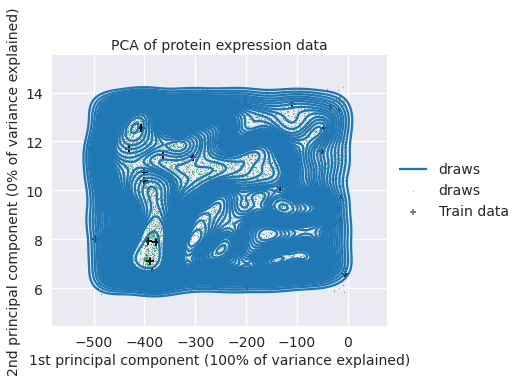

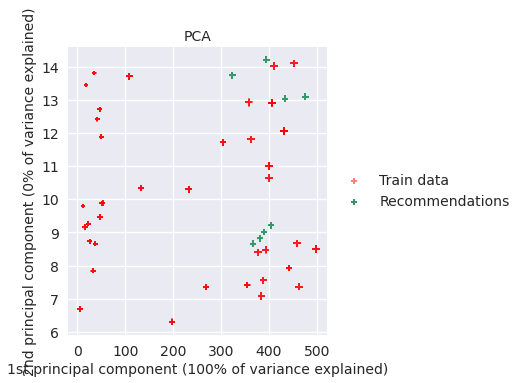

In [36]:
plot.draws_pc(art, draws, scale=100, plot_draws=True, plot_kde=True)
plot.recommendations_pc(art, scale=100)


In [37]:
df_rec_explor = art.recommendations.copy()


In [38]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )

df_rec_explor['OD340_std'] = predicted_std
df_rec_explor['Label'] = 'exploration'

In [39]:
df_rec = df_rec_exploit.append(df_rec_explor)

In [40]:
df_rec = df_rec.rename(columns={"OD340": "OD340_pred"})

### Generate the control media 

Read the standard recipe:

In [41]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [42]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Control,0.003932,0.309966,1.206566,0.01076,9.146237,0.502864,52.253707,0.00003,0.000304,0.0001,0.000726,0.000098


Check that these controls are not equivalent to the controls tested in previous cycles:

In [43]:
for component in user_params['components']:
     assert(all(df_control.at['Control', component] != control_lines[component]))

Add ART's prediction for this design

In [44]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [45]:
df_rec = df_rec.append(df_control).reset_index(drop=True)
df_rec

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
0,0.024773,0.700826,4.06276,0.047732,12.929126,2.133702,414.274311,0.00025,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation
1,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.00029,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation
2,0.00817,2.27814,5.092978,0.077865,11.739814,1.428153,411.076753,0.000279,0.000292,0.000689,0.003862,0.000014,0.511907,0.048315,exploitation
3,0.01828,2.206493,3.451213,0.059624,12.453609,0.332198,401.210566,0.000221,0.002911,0.00071,0.00435,0.000014,0.500242,0.048573,exploitation
4,0.014316,2.15443,2.710952,0.080738,10.910402,4.790117,456.776681,0.000184,0.000292,0.000689,0.001921,0.000014,0.497449,0.048050,exploitation
5,0.009734,2.242214,4.680379,0.056417,9.194358,1.921812,392.324374,0.000141,0.001184,0.000696,0.004599,0.000014,0.494262,0.047818,exploitation
6,0.033092,2.159783,3.831534,0.0665,9.140576,3.331034,469.248028,0.000276,0.001106,0.000486,0.000465,0.000014,0.490792,0.048198,exploitation
7,0.026205,2.868647,3.063754,0.051305,8.628131,5.058487,390.089741,0.00003,0.000393,0.000282,0.003961,0.000835,0.404899,0.049958,exploration
8,0.037669,0.800197,1.415873,0.084858,13.717068,1.459033,323.896805,0.000296,0.002085,0.000992,0.005032,0.000835,0.452337,0.049624,exploration
9,0.000523,2.849896,5.943808,0.079905,8.446208,4.240846,367.255495,0.000123,0.002005,0.000048,0.003702,0.000835,0.408803,0.049504,exploration


### Check the distribution of designs

Define dataframe with train data and predictions:

In [46]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

Add predictions, cv-predictions and standard deviation of the OD340 predictions:

In [49]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [50]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [51]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [52]:
df_train

Protocol,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.369218,0.047605,0.427238,0.049997,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.369218,0.047605,0.427238,0.049997,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.369218,0.047605,0.427238,0.049997,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.369218,0.047605,0.427238,0.049997,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0.2699,0.276460,0.047611,0.250693,0.052678,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.006221,0.150431,6.409492,0.07174,7.294398,1.09227,384.376373,0.00029,0.002585,0.000905,0.00288,0.000835,0.5415,0.535413,0.047618,0.565205,0.054754,train
140,0.006221,0.150431,6.409492,0.07174,7.294398,1.09227,384.376373,0.00029,0.002585,0.000905,0.00288,0.000835,0.5294,0.535413,0.047618,0.565205,0.054754,train
141,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0.2813,0.284243,0.047602,0.286457,0.044353,standard
142,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0.2755,0.284243,0.047602,0.286457,0.044353,standard


Save train data set for this cycle:

In [53]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)

In [55]:
def designs_pairwise(art, df_rec, user_params, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_train[df_train['Label']=='standard'].drop(columns='Label').values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker="+",
                s=150*df_train['OD340'],
                lw=1,
                label="Train data",
            )
            
            ax.scatter(
                standard[:, var1],
                standard[:, var2],
                c="k",
                marker="+",
                s=150*standard[:, -1].astype(float),
                lw=1,
                label="Standard",
            )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker="+",
                s=150*df_rec['OD340_pred'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X[-1, var1],
                X[-1, var2],
                c="k",
                marker="+",
                s=150*df_rec['OD340_pred'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{art.outDir}/designs_pairwise.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

Red are train data, green are recommendations, black are standards

In [57]:
import matplotlib.pyplot as plt

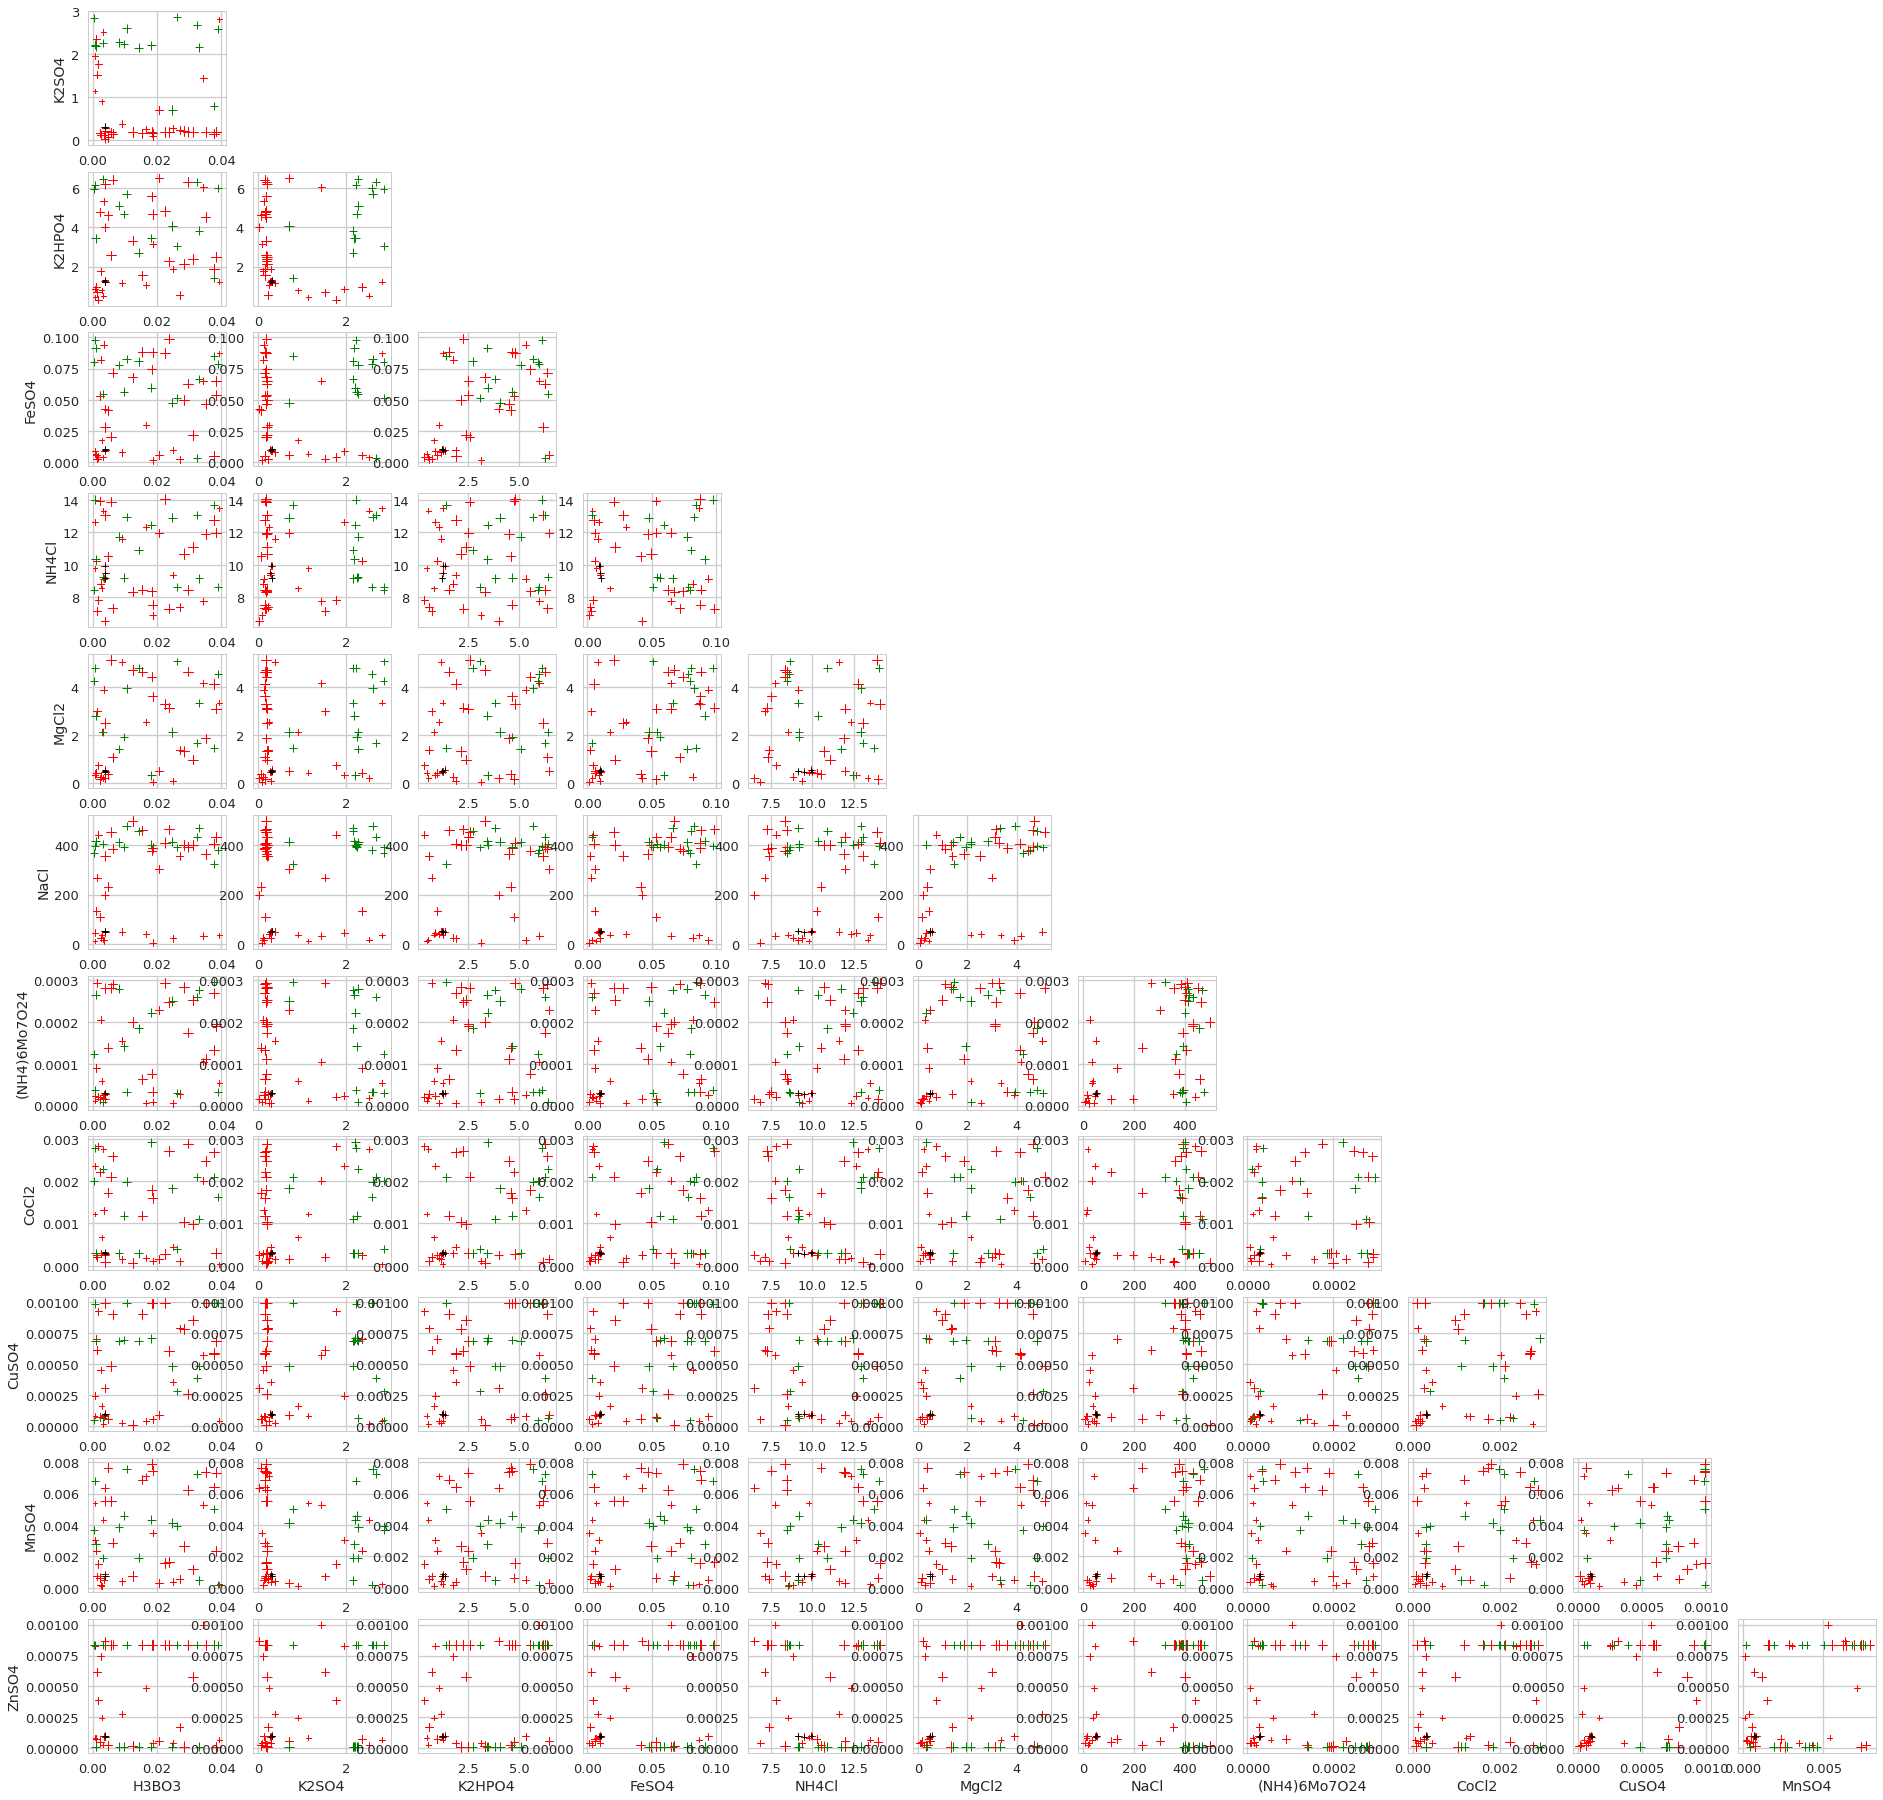

In [58]:
designs_pairwise(art, df_rec, user_params, df_train)

## Saving the generated designs

Include all replicates: 

In [59]:
df_rec = df_rec.loc[df_rec.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [60]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [61]:
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_rec['Well'] = well_names
df_rec = df_rec.set_index(['Well'])
df_rec.head()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
Well,,,,,,,,,,,,,,,
A1,0.024773,0.700826,4.06276,0.047732,12.929126,2.133702,414.274311,0.00025,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation
B1,0.024773,0.700826,4.06276,0.047732,12.929126,2.133702,414.274311,0.00025,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation
C1,0.024773,0.700826,4.06276,0.047732,12.929126,2.133702,414.274311,0.00025,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation
D1,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.00029,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation
E1,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.00029,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation


In [62]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_rec.to_csv(file) # This file will be used for the computation of volume transfers and data analysis